## Libraries

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

from utils import find_first, time_hour

## Preparing participants data

In [2]:
# List all files in the "PASS_MUSE" directory
files = os.listdir("PASS_MUSE/")
print("Files in PASS_MUSE directory:", files)

# Load the corrected markers data
markers_corrected = pd.read_csv("correctedMarkers.csv")
print("First few rows of corrected markers data:")
print(markers_corrected.head())

# Get unique participants from the corrected markers data
part_un = markers_corrected["Participant"].unique()
print("Unique participants in corrected markers data:", part_un)

# Load the target data and drop rows with missing values
target = pd.read_csv("DATA_PASS.csv")
target = target.dropna()

# Get unique participants from the target data
part = target["Participant Number"].unique()
print("Unique participants in target data:", part)

# Find the intersection of participants in both datasets
part_markcorr = np.intersect1d(part, part_un)
print("Participants present in both datasets:", part_markcorr)

Files in PASS_MUSE directory: ['2137_1.mat', '2113_1.mat', '2111_1.mat', '2135_1.mat', '2108_1.mat', '2131_1.mat', '2115_1.mat', '2117_1.mat', '2131_2.mat', '2133_1.mat', '2110_1.mat', '2109_1.mat', '2134_1.mat', '2136_1.mat', '2112_1.mat', '2116_1.mat', '2132_1.mat', '2148_1.mat', '2130_1.mat', '2114_1.mat', '2129_1.mat', '2103_2.mat', '2125_1.mat', '2118_1.mat', '2144_1.mat', '2103_3.mat', '2146_1.mat', '2103_1.mat', '2144_3.mat', '2144_2.mat', '2127_1.mat', '2123_1.mat', '2142_1.mat', '2107_1.mat', '2138_1.mat', '2144_5.mat', '2140_1.mat', '2105_1.mat', '2121_1.mat', '2144_4.mat', '2124_2.mat', '2102_1.mat', '2147_1.mat', '2126_1.mat', '2143_4.mat', '2119_1.mat', '2124_1.mat', '2145_1.mat', '2104_1.mat', '2141_1.mat', '2143_3.mat', '2139_1.mat', '2143_2.mat', '2120_1.mat', '2104_2.mat', '2122_1.mat', '2106_1.mat', '2143_1.mat']
First few rows of corrected markers data:
             timestamp  Status  Participant
0  2017-03-03 09:20:59      10         2101
1  2017-03-03 09:23:26     

## Visualization of the raw EEG

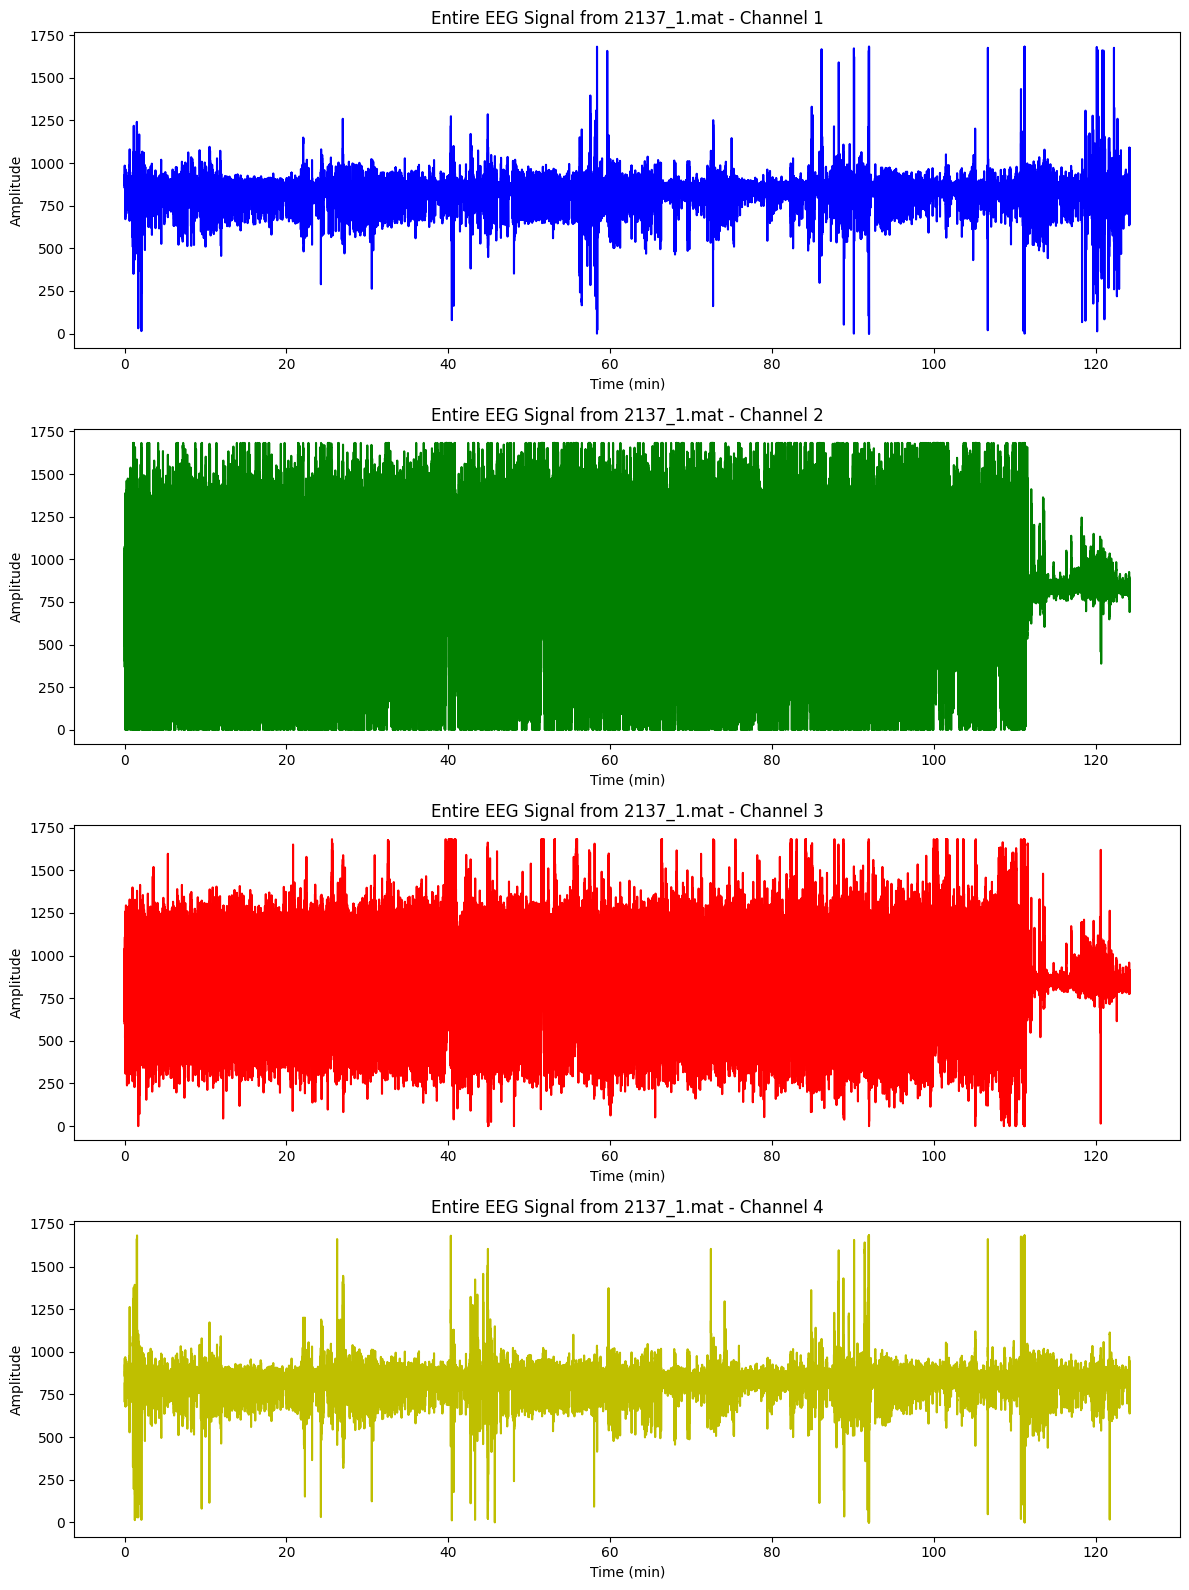

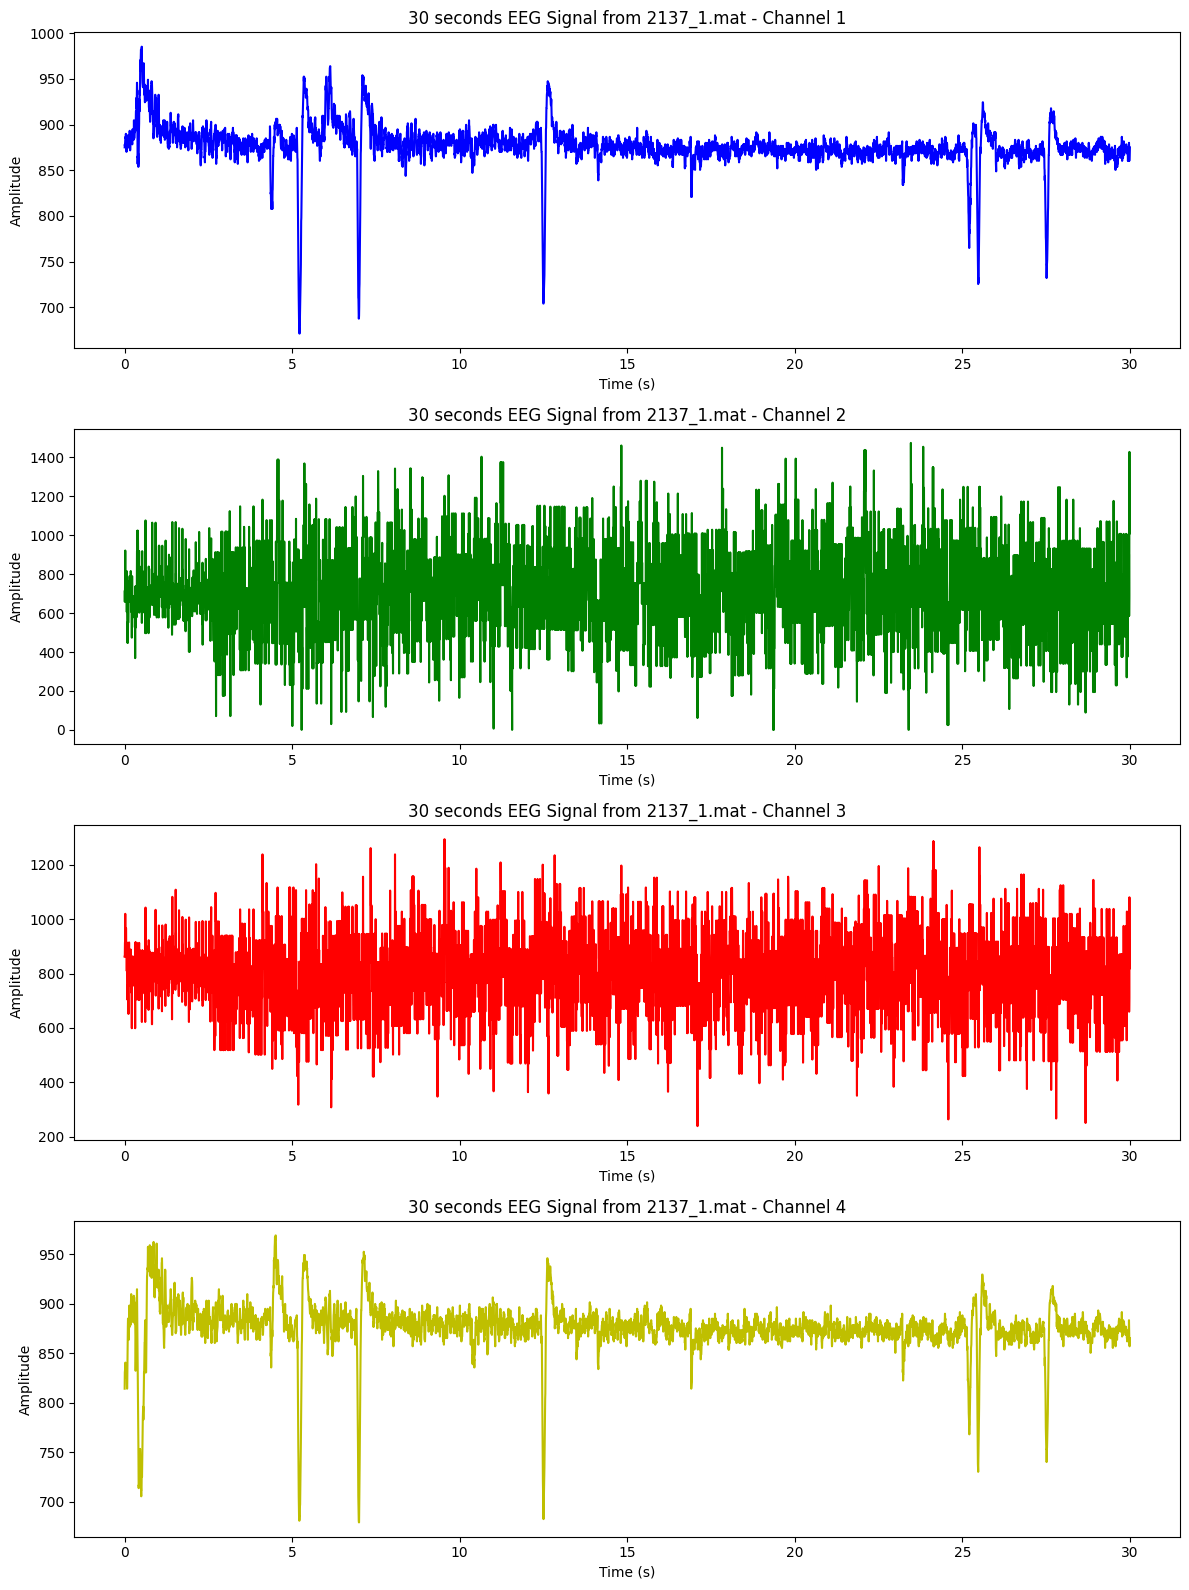

In [3]:
# Load the .mat file
mat_file = scipy.io.loadmat("PASS_MUSE/2137_1.mat")

# Extract the wwg signal
eeg_signal = mat_file['data_eeg']

# Plot the EEG signal for all 4 channels
colors = ['b', 'g', 'r', 'y']
sampling_rate = 220
time_axis = np.arange(eeg_signal.shape[0]) / sampling_rate / 60  # in minutes

plt.figure(figsize=(12, 16))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(time_axis, eeg_signal[:, i], color=colors[i])
    plt.title(f'Entire EEG Signal from 2137_1.mat - Channel {i+1}')
    plt.xlabel('Time (min)')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Plot a zoomed version
zoomed_signal = eeg_signal[:6600]  # 30 seconds of data
time_axis = np.arange(zoomed_signal.shape[0]) / sampling_rate
plt.figure(figsize=(12, 16))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(time_axis, zoomed_signal[:, i], color=colors[i])  # 30 seconds of data
    plt.title(f'30 seconds EEG Signal from 2137_1.mat - Channel {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## Preprocessing the signal

In [4]:
# Dictionary to store signals for each participant
participant_signals = {}

# Iterate over all files in the directory
for f in range(len(files)):
    participant_id = int(files[f][:4])
    
    # Check if the participant is in the corrected markers list
    if participant_id in part_markcorr:
        # Load the EEG signal from the .mat file
        signal = scipy.io.loadmat("PASS_MUSE/" + files[f])['data_eeg']

        # Load the time markers from the corresponding .mat file
        time = scipy.io.loadmat("PASS_MUSE_metdat/" + files[f][:4] + "_time" + files[f][4:])['data_markers']
        
        # Convert time markers to a list and then to hour format
        timestamps = list(time[:])
        time_vct = time_hour(timestamps)

        # Extract timestamps and statuses for the current participant from the corrected markers
        time_p = markers_corrected.loc[markers_corrected['Participant'] == participant_id, 'timestamp'].values
        status_p = markers_corrected.loc[markers_corrected['Participant'] == participant_id, 'Status'].values

        # Find the first occurrence of each timestamp in the time vector
        first_occ = find_first(time_vct, time_p)

        # Dictionary to store segments for each status
        segments = {}
        counter = 0
        counter_yuyu = 1

        # Iterate over each segment defined by the first occurrences
        for start, end in zip(first_occ[:-1], first_occ[1:]):
            segment = signal[start:end]
            key = status_p[counter]
            new_key = str(key)

            # Ensure unique keys for segments with the same status
            if new_key in segments:
                new_key += "_" + str(counter_yuyu)
                counter_yuyu += 1

            # Store the segment in the dictionary
            segments[new_key] = segment
            counter += 1

        # Store the segments for the current participant in the main dictionary
        part_key = files[f][:6]
        participant_signals[part_key] = segments

In [5]:
np.save("../Data/eeg_signals.npy", participant_signals)